In [4]:
#!/usr/bin/python
#
# solve lorenz system, use as example for ODE solution
#
import numpy as np              # numpy arrays
import matplotlib as mpl        # for plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation
from scipy import integrate     # scipy ODE routine
import ode                      # our ODE routines

C:\Users\dl27583\AppData\Local\Temp\ipykernel_29456\2462452265.py:91: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


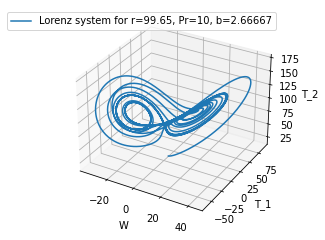

In [6]:
#
# define problem
#
class parameters:               # parameters for functions, default values
    r = 10.                     # Rayleigh number, 28
    Pr = 10                     # Prandtl number
    b = 8./3.                   # wavelength (beta) parameter 
#
# define functions for ODE solvers, need to be in f(t,x,par) format
#
# Lorenz equations, dx/dt for W, T1, T2
ndim = 3
vlabel=['W', 'T_1', 'T_2']  # labels for the variables
def f0(t,x,par): # dW/dt = Pr (T1 - W)
    return par.Pr * (x[1]-x[0])
def f1(t,x,par): # dT1/dt = -W T2 + rW - T1
    return -x[0] * x[2] + par.r * x[0] - x[1];
def f2(t,x,par): # dT2/dt = W T1 - b T2
    return x[0] * x[1] - par.b * x[2];
f = [f0,f1,f2]              # functions for the time derivatives of W, T1, T2


x = [1,8,14]             # initial conditions
#x = [0,0.5,0.5]             # initial conditions
#x = [.1,.1,.1]             # initial conditions

par = parameters()          # set parameters
#par.r = 350                     # single orbit +-
#par.r = 100.5                     # orbit ++-
#par.r = 160                     #  orbit ++--
par.r = 99.65                     #  orbit +--+--
#par.r = 28  # chaotic
#par.r = 10  # stable

#
# solver parameters
#
hs = .002                  # timestep
#nsteps = 30000              # total number of steps
nsteps = 5000              # total number of steps
ntracks = 1                 # number of states to track (not implemented yet)
xout = np.empty((nsteps,3))     # pre-allocate stored output
time = np.empty(nsteps)     # pre-allocate stored output times
itime= np.arange(0,nsteps)             # timestep index

# plotting
# which part of the solution should we plot?
pindex=itime                    # whole time series
#pindex=np.arange(nsteps-3000,nsteps) # last 3000 steps
#pindex=np.arange(nsteps-20000,nsteps) # last 20000 steps
#pindex=np.arange(0,1000) # first 1000 steps
#pindex=np.arange(0,2000) # first 2000 steps
pmode = 2                       # 1: plot solution against time
                                # 2: phase space plot
                                # 3: animation
idim=range(ndim)            # indexing array
external_ode_solver = 1        # which solver should we use?

if external_ode_solver == 1:
    def deriv(x, t, loc_par=par):    # define the derivative functions
        return [f[0](t,x,loc_par), f[1](t,x,loc_par), f[2](t,x,loc_par)]
    time = np.linspace(0,nsteps*hs, nsteps) # set up time vector
    xout = integrate.odeint(deriv, x, time,rtol=1e-5) # integrate using SciPy
else:                            # my solver
    t=0
    for i in itime:      # timestep 
        xout[i][:] = x          # store x
        time[i] = t                 # store time
        # update x
        # x = ode.euler(t,x, f, ndim, hs,par)
        # x = ode.midpoint(t,x, f, ndim, hs,par)
        x = ode.runge_kutta(t,x,f, ndim, hs,par)
        # update time
        t = t + hs                  # allow for variable timestep, in case

#
# make plots
title_string='Lorenz system for r=%g, Pr=%g, b=%g' % (par.r,par.Pr,par.b)
if pmode == 1:
    ax = [None,None,None]
    fig, ax = plt.subplots(nrows=ndim, sharex=True) # make column of ndim rows plot
    plt.xlabel('time')
    for i in idim:
        if i==0:
            ax[i].set_title(title_string)
        ax[i].plot(time[pindex],xout[pindex,i])
        ax[i].set_ylabel(vlabel[i])

elif pmode == 2:                # 3D plot
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(xout[pindex,0], xout[pindex,1], xout[pindex,2], label=title_string)


    ax.set_xlabel(vlabel[0])
    ax.set_ylabel(vlabel[1])
    ax.set_zlabel(vlabel[2])

    ax.legend()

elif pmode == 3:                # 3D animation of trajectory
    fig = plt.figure()
    # Set up figure & 3D axis for animation
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1], projection='3d')
    #ax.axis('off')

    ax.plot(xout[pindex,0], xout[pindex,1], xout[pindex,2], label=title_string)
    ax.set_xlabel(vlabel[0])
    ax.set_ylabel(vlabel[1])
    ax.set_zlabel(vlabel[2])
    ax.legend()


    # set up lines and points
    lines = []
    pts = []
    colors = plt.cm.jet(np.linspace(0, 1, 2*ntracks))
    
    for i in np.arange(0,2,2*ntracks):
        lines += ax.plot([], [], [], '-', colors[i])
        pts += ax.plot([], [], [], 'o', colors[i+1])

    # prepare the axes limits
    #ax.set_xlim((-25, 25))
    #ax.set_ylim((-35, 35))
    #ax.set_zlim((5, 55))

    # set point-of-view: specified by (altitude degrees, azimuth degrees)
    ax.view_init(30, 0)

    # initialization function: plot the background of each frame
    def init():
        for line, pt in zip(lines, pts):
            line.set_data([], [])
            line.set_3d_properties([])
            
            pt.set_data([], [])
            pt.set_3d_properties([])
        return lines + pts

        # animation function.  This will be called sequentially with the frame number
    def animate(i):
        # we'll step two time-steps per frame.  This leads to nice results.
        # i = (2 * i) % x_t.shape[1]
        ip=i*10
        for line, pt, xi in zip(lines, pts, xout):
            x, y, z = xout.T
            
            line.set_data(x, y)
            line.set_3d_properties(z)
            
            pt.set_data(x[ip], y[ip])
            pt.set_3d_properties(z[ip])
            
        # rotate the point of view
        ax.view_init(30, 0.3 * i)
        fig.canvas.draw()
        return lines + pts

    # instantiate the animator1.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=500, interval=30, blit=True)
    anim.save('lorenz_attractor.mp4', fps=15, extra_args=['-vcodec', 'libx264'])
else:
    print ('pmode',pmode,' undefined')

        

plt.show()
